In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

In [3]:
PATH=Path('..')/'data/awdlstm/data/penn/'

In [4]:
LM_PATH=Path('..')/'data/lm/models/penn/'
LM_PATH.mkdir(exist_ok=True)
LM_PATH_TMP = LM_PATH/'tmp'

## Load parsed data

In [5]:
trn_lm = np.load(LM_PATH_TMP/'trn_ids.npy')
val_lm = np.load(LM_PATH_TMP/'val_ids.npy')
itos = pickle.load(open(LM_PATH_TMP/'itos.pkl', 'rb'))

In [6]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(9698, 42068)

In [7]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

## Language Model

In [8]:
#embedding size, humber of hidden and layers all from wt103 trained by JH
em_sz = 400
nh = 1150
nl = 3

In [9]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [10]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [11]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 

In [45]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [46]:
lr=1e-3
lrs = lr

In [14]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      5.811733   5.685369   0.18555   



[array([5.68537]), 0.1855499181266239]

In [15]:
learner.save('lm_penn_1')

In [47]:
learner.load('lm_penn_1')

In [48]:
#learner.lr_find(start_lr=lrs/100, end_lr=lrs, linear=True)
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 32%|███▏      | 93/295 [00:09<00:20,  9.82it/s, loss=5.7]

Exception in thread Thread-38:
Traceback (most recent call last):
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 81%|████████  | 238/295 [00:23<00:05,  9.95it/s, loss=25.3]


In [49]:
learner.sched.plot(linear=True)

TypeError: plot() got an unexpected keyword argument 'linear'

 81%|████████  | 238/295 [00:39<00:09,  6.05it/s, loss=25.3]

In [36]:
def phases_1cycle(cycle_len,lr,div,pct,max_mom,min_mom):
    tri_cyc = (1-pct/100) * cycle_len
    return [TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=cycle_len-tri_cyc, opt_fn=optim.SGD, lr=(lr/div,lr/(100*div)), lr_decay=DecayType.LINEAR, 
                          momentum=max_mom)]

In [38]:
learner.fit_opt_sched(phases_1cycle(3, 1e-3, 10, 10, 0.95, 0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 30%|██▉       | 88/295 [00:08<00:21,  9.81it/s, loss=3.77]

Exception in thread Thread-34:
Traceback (most recent call last):
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      3.783663   4.083364   0.346888  
    1      3.779865   4.080362   0.346744  
    2      3.764145   4.078246   0.34696   



[array([4.07825]), 0.3469597061475118]

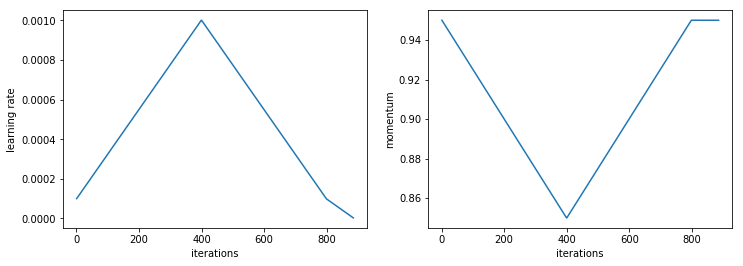

In [40]:
learner.sched.plot_lr(show_text=False)

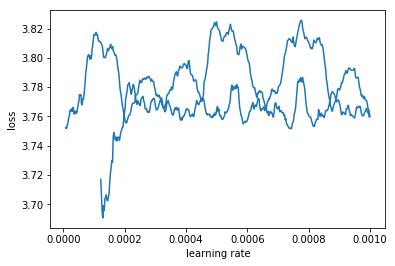

In [41]:
learner.sched.plot(linear=True)

In [19]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      5.237557   5.134226   0.255799  



[array([5.13423]), 0.25579854367070043]

In [20]:
learner.save('lm_penn_2')

In [21]:
learner.load('lm_penn_2')

In [22]:
vals, ep_vals = learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15, get_ep_vals=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      5.060701   4.958785   0.269427  
    1      4.768993   4.700524   0.288313  
    2      4.528906   4.52349    0.30493   
    3      4.374942   4.554773   0.307546  
    4      4.262603   4.351722   0.320431  
    5      4.173705   4.284385   0.3265    
    6      4.090768   4.234958   0.329909  
    7      4.03144    4.209898   0.333104  
    8      3.977848   4.169682   0.337434  
    9      3.922018   4.145669   0.33859   
    10     3.878303   4.129487   0.341142  
    11     3.839239   4.112318   0.343302  
    12     3.831067   4.096435   0.344988  
    13     3.801114   4.094064   0.345515  
    14     3.787229   4.083477   0.346665  



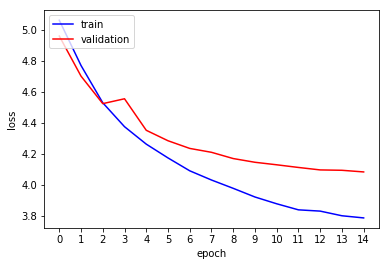

In [23]:
plot_ep_vals(ep_vals)

In [24]:
learner.save('lm_penn_3')

In [25]:
learner.save_encoder('lm_penn_3_enc')

### Try with lower learning rate, more dropout

TODO use new training API to optimize this

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.8
#re - run learner section above

In [ ]:
lr = 1e-3
lrs = lr

In [ ]:
learner.lr_find(start_lr=lrs/100, end_lr=lrs*10, linear=True)

In [ ]:
learner.sched.plot()

In [ ]:
learner.load('lm_penn_3')

In [ ]:

vals, ep_vals = learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15, get_ep_vals=True)

In [ ]:
plot_ep_vals(ep_vals)

In [ ]:
learner.save('lm_penn_4')

In [ ]:
learner.save_encoder('lm_penn_4_enc')

### Generate text

In [ ]:
learner.load("lm_penn_v2_3")

In [ ]:
m = learner.model
m.eval()
m[0].bs = 1

## Inference

In [ ]:
sen = """some words"""

In [ ]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

In [ ]:
VV(idxs)

In [ ]:
probs = learner.model(VV(idxs))

In [ ]:
type(probs), len(probs)

In [ ]:
learner.model

In [ ]:
probs[0].shape, [x.shape for x in probs[1]], [x.shape for x in probs[2]]

In [ ]:
# probs[0] is most likely the output vector

### Arvind's answer

In [ ]:
def get_next(inp):
#     m[0].bs = 1 ## why?
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #pdb.set_trace()
    i = np.argmax(to_np(p)[0], 1)[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #i = np.argmax(to_np(p)[0], 1)[0]
    i = torch.topk(p[0][-1], 1)[1].data[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    m[0].bs =1
    #print(inp)
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    try:
        r = itos[pred]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        # res += c # ???
        res = res + " " + c
        #print(res)
        inp = inp.strip().split(" ") + [c]        
#         inp = ' '.join(inp[1:])
        inp = ' '.join(inp)
        
    return res

In [ ]:
m = learner.model
m.eval()
m[0].bs = 1

In [ ]:
sen = """fincial system meltdown"""
get_next_n(sen, 10)

In [ ]:
sen = """fraudulent activities by"""
get_next_n(sen, 10)


In [ ]:
sen = """accounting cost of"""
get_next_n(sen, 10)